In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *

In [ ]:
@cache_disk("full_hai")
def load_data():
    return read_fluxnet_csv(hai_path, None)

hai = load_data()

In [ ]:
model = KalmanFilter(n_dim_state = hai.shape[1], n_dim_obs=hai.shape[1])

In [ ]:
model._set_constraint('obs_cov', model.obs_cov * 1e-1, train=False)

In [ ]:
model.obs_cov

tensor([[0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.1000]])

In [ ]:
dls = make_dataloader(hai, 200, 10, bs=1) 

In [ ]:
learn = Learner(dls, model, loss_func=imp_ll_loss)

In [ ]:
learn.fit(10, 1e-2)

epoch,train_loss,valid_loss,time
0,3.635745,1.710642,00:06
1,3.478960,1.882065,00:07
2,2.521641,0.858235,00:07
3,2.154934,-0.025799,00:07
4,2.415284,0.131528,00:07
5,1.808749,2.223077,00:07
6,1.243215,-1.365741,00:07
7,0.886994,-0.651894,00:07
8,0.361812,-0.216400,00:07
9,0.383236,-2.003717,00:07


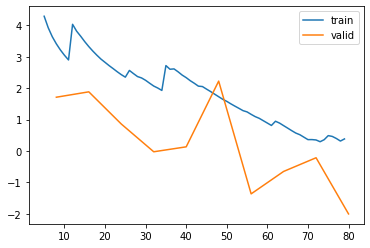

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# learn.fit(10, 1e-2)

epoch,train_loss,valid_loss,time
0,-0.136441,-2.783123,00:06
1,-0.205623,9.796312,00:07
2,-0.540875,-2.835373,00:07
3,-0.982134,-1.059306,00:07
4,-1.409189,-2.904365,00:07
5,-0.989693,-2.092275,00:07
6,-0.506454,14.610399,00:07
7,-0.230669,-2.226961,00:07
8,-0.627711,-1.566376,00:07
9,-0.887778,22.012627,00:07


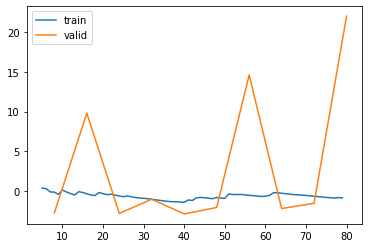

In [ ]:
# learn.recorder.plot_loss()

In [ ]:
trained_state = learn.model.state_dict()

## Results

In [ ]:
from meteo_imp.data_preparation import MeteoDataTest
from meteo_imp.kalman.imputation import KalmanImputation

In [ ]:
def gap2res(var_sel, gap_len, gap_start, block_start=1000, block_end=1200):
    data = MeteoDataTest(hai.iloc[block_start:block_end, :]).add_gap(gap_len, var_sel, gap_start)
    imp = KalmanImputation(data.data)
    imp.model.filter.load_state_dict(trained_state)
    return imp.to_result(data.data_compl_tidy, var_names= data.data.columns, units=units, pred_all=True)

In [ ]:
data = MeteoDataTest(hai)

In [ ]:
var_sel = data.data.columns

In [ ]:
%time gap2res(var_sel, 10, 10)

CPU times: user 3.39 s, sys: 60.8 ms, total: 3.45 s
Wall time: 577 ms


Imputation Result:
        N obs: 200

In [ ]:
gaps = [2, 5, 7, 10, 20, 30, 50, 100]
gap_starts = [0, 30, 60, 90]

In [ ]:
from ipywidgets import interact_manual, IntSlider

In [ ]:
#| include: false
@interact_manual(TA=True,
                 SW_IN=True,
                 VPD=True,
                 gap_len=IntSlider(10, 1,100),
                 gap_start=IntSlider(30, 1,100),
                 block_start = IntSlider(1000, 0, 20_000, 1000),
                 block_len = IntSlider(200, 10, 1000, 10)
        )
def show_diff_gaps_res(TA, SW_IN, VPD, gap_len, gap_start, block_start, block_len):
    var_sel = []
    if TA: var_sel.append('TA')
    if SW_IN: var_sel.append('SW_IN')
    if VPD: var_sel.append('VPD')
    var_sel = (*var_sel,)
    gap2res(var_sel, gap_len, gap_start, block_start, block_start + block_len).display_results()
    

interactive(children=(Checkbox(value=True, description='TA'), Checkbox(value=True, description='SW_IN'), Check…